In [369]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# [Sloan Digital Sky Survey DR14](https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey)

## 1. Загружаем данные

In [330]:
path = '../data/Skyserver_SQL2_27_2018 6_51_39 PM.csv'
data_raw = pd.read_csv(path)

In [331]:
data_raw

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


### Описание данных

Таблица содержит данные о `10_000` наблюдений космического пространства, сделанных `SDSS`. Каждое наблюдение описывается 17 столбцами характеристик и 1 столбцом класса, который идентифицирует его как звезду, галактику или квазар.

In [332]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Характеристики наблюдений, сделанных `SDSS`, имеют значения:

---

Параметры фото:
+ `objid` - идентификатор объекта 
+ `ra` - прямое восхождение (в градусах)
+ `dec` - склонение (в градусах)

**Пара значений `(ra, dec)` является координатами небесного тела относительно Солнца в момент мартовского равноденствия в экваториальной системе координат.* Подробнее [тут](https://en.wikipedia.org/wiki/Declination).

---

Параметры фотометрической системы `SDSS`:
+ `u` - значение `U` фильтра
+ `g` - значение `G` фильтра
+ `r` - значение `R` фильтра
+ `i` - значение `I` фильтра
+ `z` - значение `Z` фильтра

**Система астрономических величин Туана-Ганна. u g, r, i, z представляют значения 5 фильтров телескопа.* Подробнее [тут](https://en.wikipedia.org/wiki/Photometric_system).
  
---

Местоположение объекта на общем сканировании (фотографии):
+ `run` - идентификатор конкретного сканирования
+ `rerun` - дополнительное значение показываюзщее тип обработки 
+ `camcol` - номер линии сканирования (от 1 до 6)
+ `field` - номер области сканирования

**Изображение, полученное телескопом, имеет разрешение 2048x2048 пикселей. Телескоп сканирует небесное пространство по линиям, идентифицируя положение небесного тела на линии номером области.*

---

Спецификация объекта:
+ `specobjid` - идентификатор в выборке спектральных галактик

---

Астрофизические параметры:
+ `redshift` - красное смещение (сдвиг излучаемой небесном телом волны в красный спектр)
+ `plate` - идентификатор пластины `SDSS`
+ `mjd` - юлианская дата наблюдения (в днях)
+ `fiberid` - идентификатор оптического волокна `SDSS`

**При каждой спектроскопической экспозиции используется большая, тонкая, круглая металлическая пластина, которая размещает оптические волокна через отверстия, просверленные в местах расположения изображений в фокальной плоскости телескопа. Затем эти волокна поступают в спектрографы. Каждая пластина имеет уникальный серийный номер, связанный с SpecObj.*

---

Почитать подробнее про исследование можно [тут](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey).

Требуется предсказать значения (`'STAR'`, `'GALAXY'`, `'QSO'`) категориального признака `class` по остальным признакам. Это *задача классификации*.

In [333]:
data_raw['class'] = data_raw['class'].astype('category')

#### Информация о числовых признаках

In [334]:
data_raw.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


#### Инфомация о категориальных признаках

In [335]:
data_raw.describe(include=['category'])

,class
count,10000
unique,3
top,GALAXY
freq,4998


### Пропущенные значения

Наблюдения не имеют пропусков

### Ненужные значения

Справедливо заметить, что характеристики `objid` и `specobjid` отражают лишь идентификатор и не относят объект к какому либо классу (с точки зрения координат объекта или других астрофизических параметров). Таким же образом характеристики `run`, `rerun`, `camcol` и `field` связаны лишь с местоположением исследуемого объекта на общем снимке.

Проверим гипотезу:

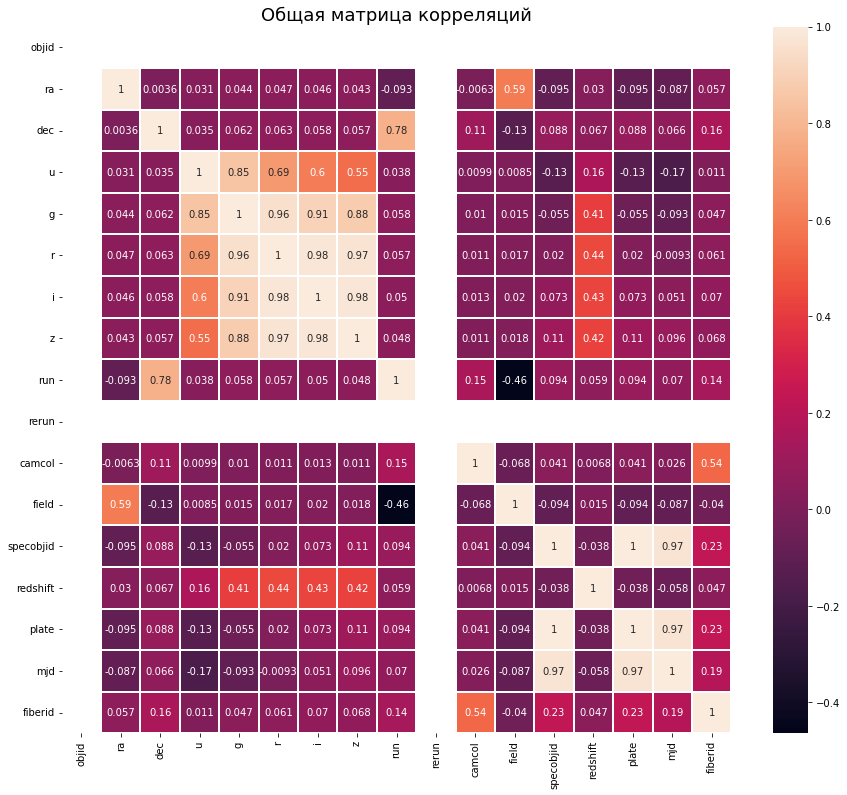

In [336]:
plt.figure(figsize=(15,13))
g = sns.heatmap(data_raw.corr(), linewidths=.1, annot=True)
g.set_title('Общая матрица корреляций', size=18)
pass

По матрице корреляций сразу видно, что `objid` и `rerun` вообще не имеют смысла так как имеют всего одно уникальное значение. Средняя (0.59) и большая (0.78) корреляция между парами `field`, `ra` и `run`, `dec` соответственно, объясняется методом сканирования небосного пространства (сканирования происходят при разных восхождениях и области на изображении зависит от склонения). `specobjid` коррелирует тоолько со своим образующим параметром (`mjd`) и тем, что зависит от него по определению (`plate`).

Гипотеза верна. Можно избавиться от столбцов `objid`, `run`, `rerun`, `camcol`, `field`, `specobjid`.

In [337]:
data_raw.drop(columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], inplace=True)

### Получение X и y

Для предсказания класса наблюжения будем использовать все входные признаки, кроме `objid` и `rerun`

In [338]:
X = data_raw.drop(columns=['class'])
y = data_raw['class']

In [339]:
data_raw['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## 2. Визуализация

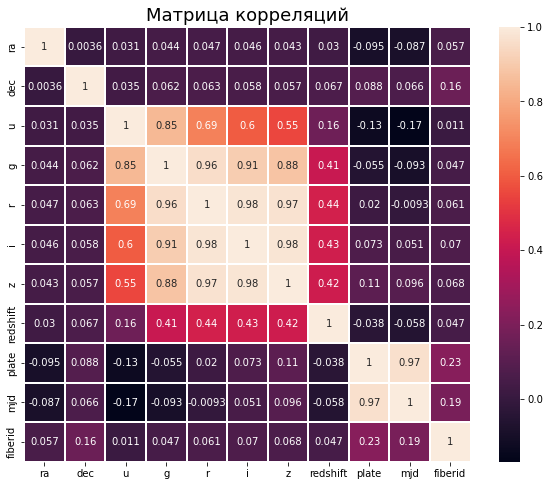

In [340]:
plt.figure(figsize=(10,8))
g = sns.heatmap(X.corr(), linewidths=.1, annot=True)
g.set_title('Матрица корреляций', size=18)
pass

Будем исследовать 4 области: 
+ распределение `redshift`
+ связи `ra` и `dec`
+ отношение параметров `u`, `g`, `r`, `i`, `z`
+ отношение `plate` и `mjd`

### Распределение красного смещения

STAR    E=0.000043 D=0.000410
GALAXY  E=0.080325 D=0.046036
QSO     E=1.218366 D=0.697699


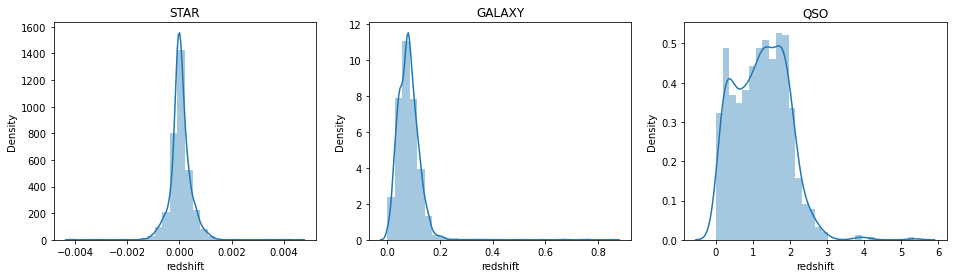

In [341]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for ax, cls in zip(axes, y.unique()):
    g = sns.distplot(X[y == cls].redshift, bins=30, kde=True, ax=ax)
    g.set_title(cls)

    E = X[y == cls].redshift.mean()
    D = X[y == cls].redshift.std()
    print(f'{cls: <7} {E=:.6f} {D=:.6f}')
pass

Сразу видно, что значения красного смещения для классов различается: 
+ *STAR* - выглядит как $N(0, \sigma^2)$ 
+ *GALAXY* - выглядит как $N(0.75, \sigma^2)$ 
+ *QSO* - имеет меньше всего значений по сравнению с другими классами, скорее всего также выглядит как $N(1.2, \sigma^2)$. 

Для боллее точного представления можно убрать выбросы.

В общем, красное смещение выглядит как достаточно хороший параметр, по которому можно различать эти 3 класса.

#### Красное смещение без выбросов

STAR    E=0.000040 D=0.000272
GALAXY  E=0.077445 D=0.034410
QSO     E=1.203813 D=0.664989


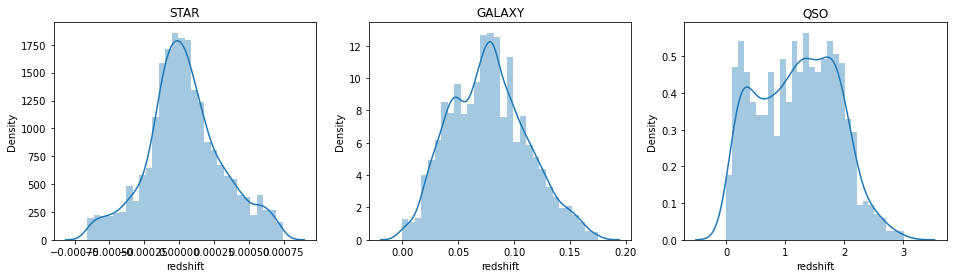

In [342]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for ax, cls in zip(axes, y.unique()):
    rs = X[y == cls].redshift

    Q1, Q3 = rs.quantile([.25, .75])
    IQR = Q3 - Q1
    lo, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    rs = rs[(rs > lo) & (rs < up)]

    g = sns.distplot(rs, bins=30, kde=True, ax=ax)
    g.set_title(cls)

    E = rs.mean()
    D = rs.std()
    print(f'{cls: <7} {E=:.6f} {D=:.6f}')
pass

### Связи `ra` и `dec`

In [343]:
def ra_dec_to_xyz(ra, dec):
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (
        cos_ra * sin_dec,
        sin_ra * sin_dec,
        cos_dec
    )

In [344]:
def draw_ra_dec(ra, dec, labels):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)

    wf = ax.plot_wireframe(x, y, z, color="grey")
    wf.set_alpha(0.25)

    # draw observations
    x, y, z = ra_dec_to_xyz(data_raw.ra, data_raw.dec)
    clrs = LabelEncoder().fit_transform(labels)
    sc = ax.scatter(x, y, z, c=clrs, s=40, alpha=0.01)

    ax.view_init(30, 190)

    ax.grid(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    plt.title('Экваториальные координаты', size=18)

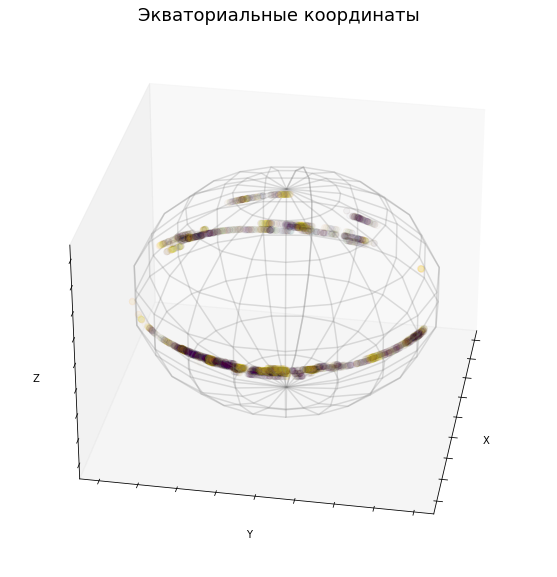

In [345]:
draw_ra_dec(data_raw.ra, data_raw.dec, y)

Видно, что классы небесных тел одинаково распределены среди пар склонений и восхождений.  

#### Распределение `dec`

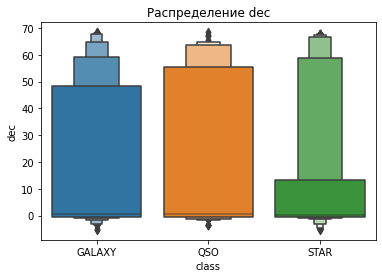

In [346]:
sns.boxenplot(
    data=data_raw.sample(1000), 
    x='class', 
    y='dec'
)
plt.title('Распределение dec')
pass

Классы имеют следующее распределение склонения:
+ *STAR* - промежуток 0 - 15 градусов
+ *GALAXY* - промежуток 15 - 45 градусов
+ *QSO* - промежуток 45 - 55 градусов

#### Распределение `ra`

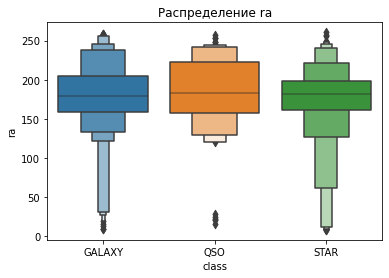

In [347]:
sns.boxenplot(
    data=data_raw.sample(1000), 
    x='class', 
    y='ra'
)
plt.title('Распределение ra')
pass

Видны выбросы, но в общем, прямое склонение для всех классов находится в одинаковом промежутке.

### Отношение параметров `u`, `g`, `r`, `i`, `z`

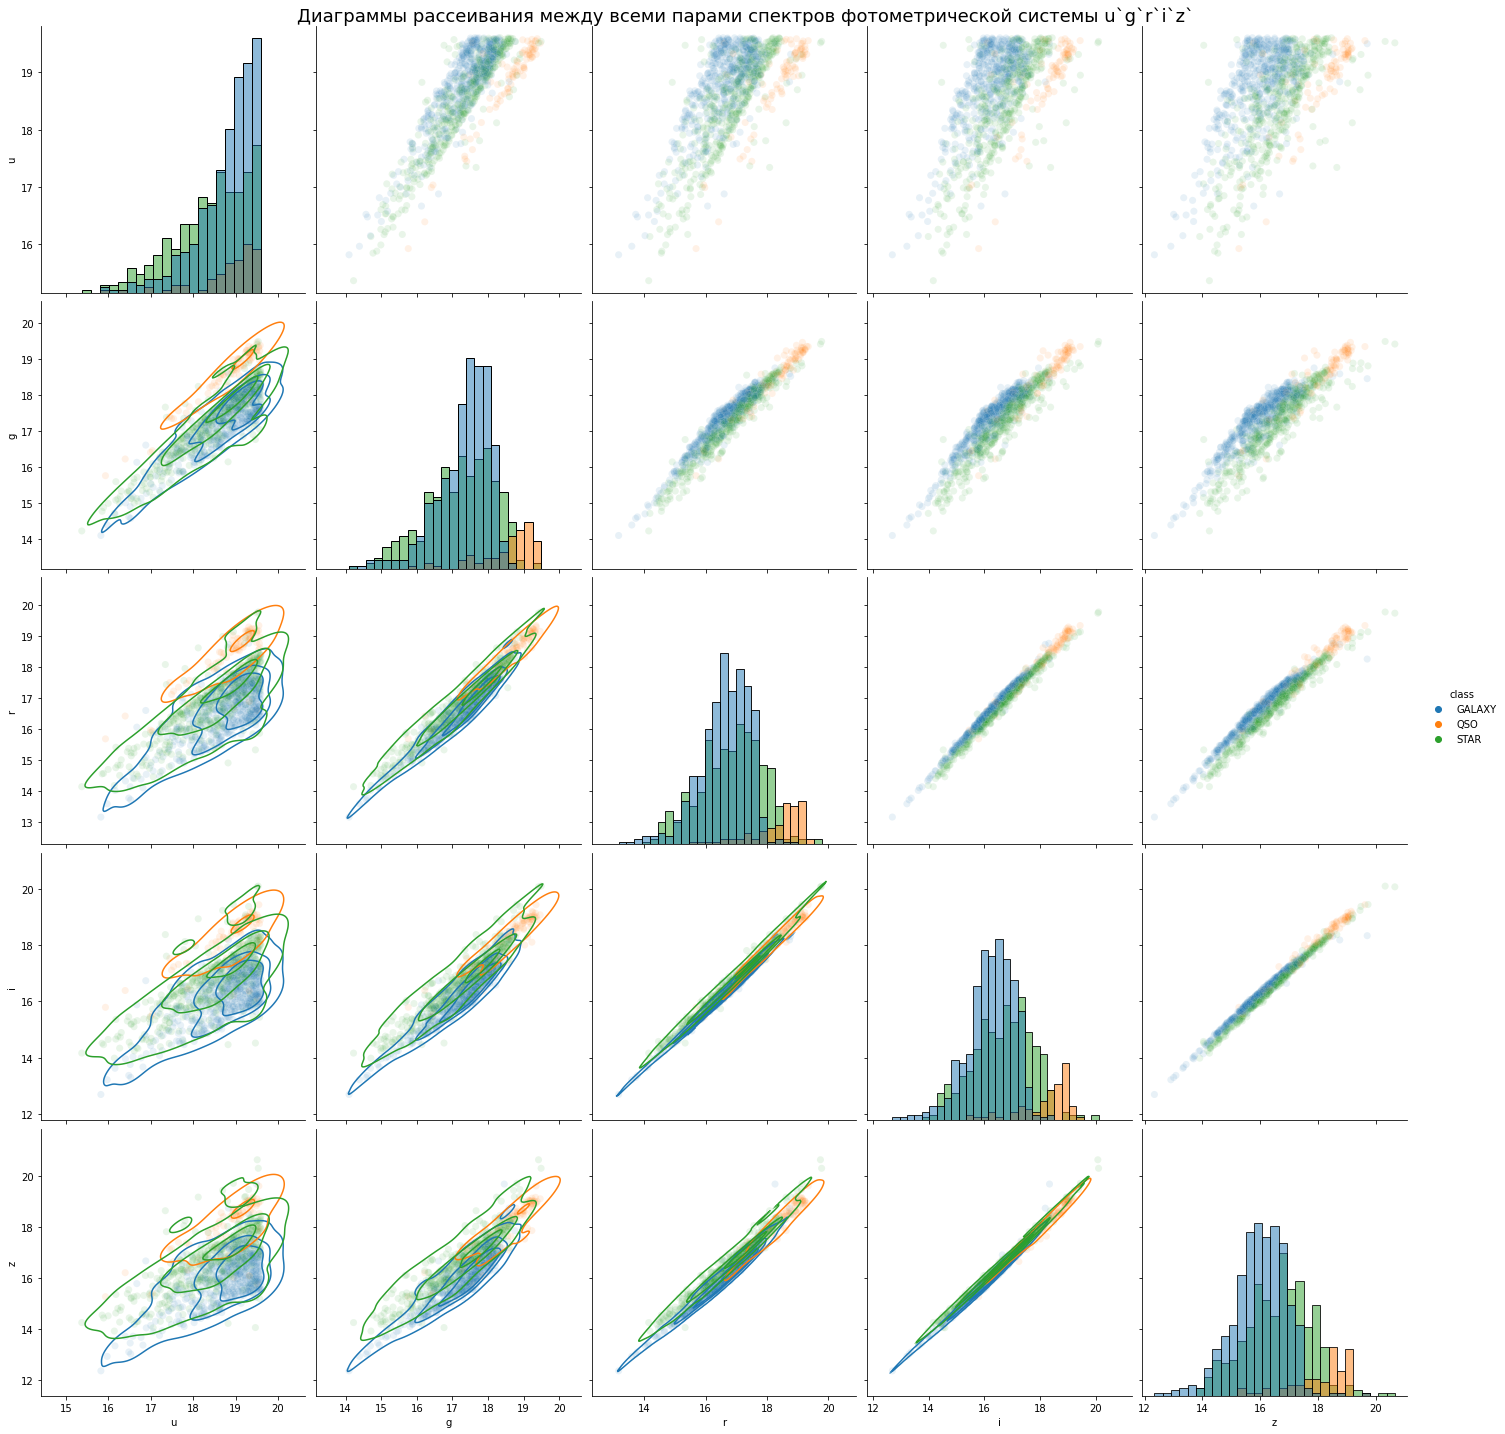

In [348]:
g = sns.pairplot(
    data_raw.sample(1000), 
    hue='class', 
    vars=['u', 'g', 'r', 'i', 'z'],
    diag_kind='hist', 
    plot_kws={'alpha': 0.1, 's': 50},
    height=4,
)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle(
    'Диаграммы рассеивания между всеми парами спектров фотометрической системы u`g`r`i`z`', 
    size=18, y=1,
)
pass

Сразу становится заметно, что на всех фильтрах классы имеют конкретные позиции группы.

#### Попарные корреляции фильтров

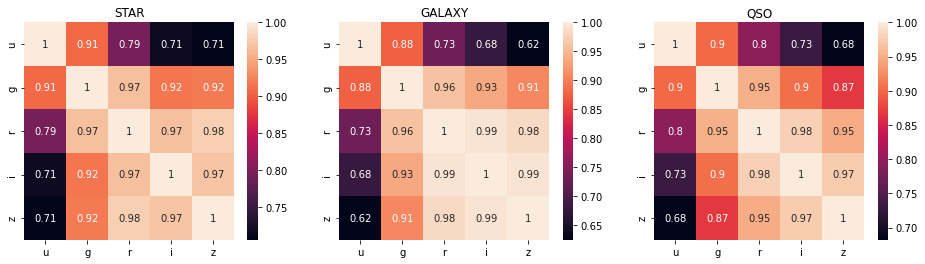

In [349]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for ax, cls in zip(axes, y.unique()):
    g = sns.heatmap(X[y == cls][['u', 'g', 'r', 'i', 'z']].corr(), ax=ax, annot=True)
    g.set_title(cls)
pass

Так как фильтры разделяют возрастающую последовательность длин волн, видна следующая зависимость: корреляция `u`-фильтра с остальными фильтрами падает; остальные же фильтры сохраняют зависимости на всех длинах волн.

В общем случае для трех классов матрицы корреляций похожи. Далее можно будет попробовать заменить эти параметры меньшим количеством.

### Отношение `plate` и `mjd`

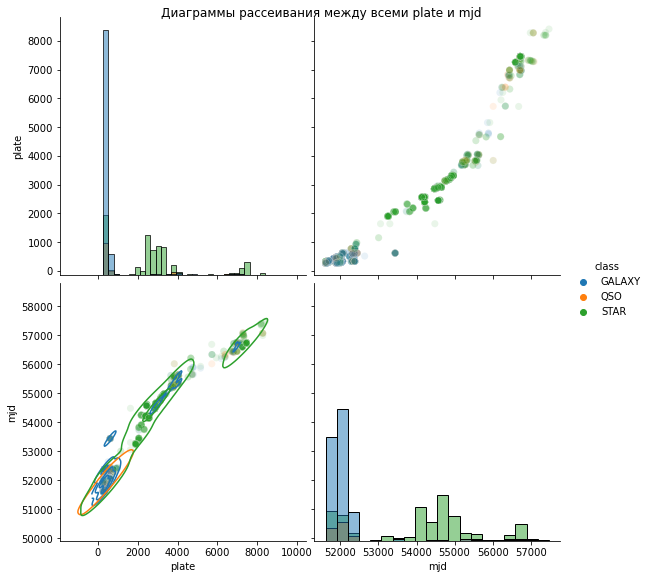

In [350]:
g = sns.pairplot(
    data_raw.sample(5000), 
    hue='class', 
    vars=['plate', 'mjd'],
    diag_kind='hist', 
    plot_kws={'alpha': 0.1, 's': 50},
    height=4,
)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle(
    'Диаграммы рассеивания между всеми plate и mjd', 
    y=1,
)
pass

Видны выбросы, но также заметно, что классы `GALAXY` и `QSO` в основном имеют меньший идентификатор пластины и меньшую юлианскую дату. 

#### Попарные корреляции

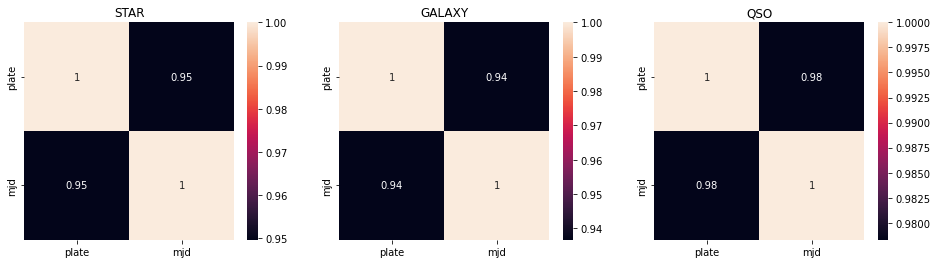

In [351]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for ax, cls in zip(axes, y.unique()):
    g = sns.heatmap(X[y == cls][['plate', 'mjd']].corr(), ax=ax, annot=True)
    g.set_title(cls)
pass

Для всех классов матрицы выглядят похожим образом.

## 3. Препроцессинг и разделение выборки

### Кодирование целевой переменной

In [352]:
y = LabelEncoder().fit_transform(y)
np.unique(y)

array([0, 1, 2])

### Метод главных компонент для переменных `u`, `g`, `r`, `i`, `z`

In [353]:
ugriz = PCA(n_components=3).fit_transform(X[['u', 'g', 'r', 'i', 'z']])

In [354]:
X = pd.concat((X, pd.DataFrame(ugriz)), axis=1)
X.rename({0: 'ugriz_1', 1: 'ugriz_2', 2: 'ugriz_3'}, axis=1, inplace=True)
X.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
X.head()

,ra,dec,redshift,plate,mjd,fiberid,ugriz_1,ugriz_2,ugriz_3
0,183.531326,0.089693,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


### Метод главных компонент для переменных `mjr` и `plate`

In [355]:
mjd_plate = PCA(n_components=1).fit_transform(X[['mjd', 'plate']])

In [356]:
X = pd.concat((X, pd.DataFrame(mjd_plate)), axis=1)
X.rename({0: 'mjd_plate'}, axis=1, inplace=True)
X.drop(['mjd', 'plate'], axis=1, inplace=True)
X.head()

,ra,dec,redshift,fiberid,ugriz_1,ugriz_2,ugriz_3,mjd_plate
0,183.531326,0.089693,-0.000009,491,-1.507202,-1.377293,-0.265119,2685.265408
1,183.598370,0.135285,-0.000055,541,-0.195758,-0.028410,-0.155695,-1725.859824
2,183.680207,0.126185,0.123111,513,1.297604,-0.590023,0.140338,-1491.007536
3,183.870529,0.049911,-0.000111,510,-1.446117,0.566685,-0.009272,2685.265408
4,183.883288,0.102557,0.000590,512,-0.849271,1.287505,-0.397689,2685.265408


### Масштабирование

In [357]:
X.describe()

,ra,dec,redshift,fiberid,ugriz_1,ugriz_2,ugriz_3,mjd_plate
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,175.529987,14.836148,0.143726,353.069400,-7.156609e-16,-3.233547e-15,-1.980858e-15,-2.168281e-12
std,47.783439,25.212207,0.388774,206.298149,2.222472e+00,6.920866e-01,1.583135e-01,2.322731e+03
min,8.235100,-5.382632,-0.004136,1.000000,-9.640301e+00,-2.018363e+00,-1.787185e+00,-1.773242e+03
25%,157.370946,-0.539035,0.000081,186.750000,-1.367704e+00,-5.081577e-01,-8.775930e-02,-1.555234e+03
50%,180.394514,0.404166,0.042591,351.000000,6.048314e-02,-3.327989e-02,-6.390920e-04,-1.433363e+03
75%,201.547279,35.649397,0.092579,510.000000,1.417466e+00,4.500008e-01,8.986401e-02,1.801515e+03
max,260.884382,68.542265,5.353854,1000.000000,1.143611e+01,7.225887e+00,2.138851e+00,8.239370e+03


Данные содержат как очень мальенькие значения, так и очень большие, в этом случае рекоммендуется использовать масштабирование данных.

Так как датасет большое количество выбросов, будем использовать `RobustScaler`.

In [358]:
X = RobustScaler().fit_transform(X)

### Разбиение выборки

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 4. Обучение моделей

Таблички для хранения метрик качества

In [360]:
time_table = pd.DataFrame(columns=('train, s', 'test, s'))
RMSE_table = pd.DataFrame(columns=('train', 'test'))
ACC_table = pd.DataFrame(columns=('train, %', 'test, %'))

Функция замерки качества

In [361]:
def fit_predict_score(model, model_name: str):
    training_start = time.perf_counter()
    model.fit(X_train, y_train)
    training_end = time.perf_counter()

    prediction_start = time.perf_counter()
    test_preds = model.predict(X_test)
    prediction_end = time.perf_counter()
    train_preds = model.predict(X_train)

    time_table.loc[model_name, :] = (
        training_end - training_start, 
        prediction_end - prediction_start
    )

    RMSE_table.loc[model_name, :] = (
        mean_squared_error(y_train, train_preds, squared=True),
        mean_squared_error(y_test, test_preds, squared=True)
    )

    ACC_table.loc[model_name, :] = (
        accuracy_score(y_train, train_preds),
        accuracy_score(y_test, test_preds)
    )

### Модели

In [362]:
model = SGDClassifier(penalty='l2')
fit_predict_score(model, 'Logit')

In [384]:
model = KNeighborsClassifier(n_neighbors=5)
fit_predict_score(model, 'K-NN')

In [385]:
model = RandomForestClassifier(n_estimators=100)
fit_predict_score(model, 'Random Forest')

In [370]:
model = SVC(kernel='linear')
fit_predict_score(model, 'LinearSVM')

In [386]:
ACC_table

,"train, %","test, %"
Logit,0.977571,0.973
K-NN,0.980857,0.972667
Random Forest,1.0,0.99
LinearSVM,0.989286,0.987667


In [387]:
RMSE_table

,train,test
Logit,0.055,0.064
K-NN,0.064571,0.091333
Random Forest,0.0,0.022
LinearSVM,0.027857,0.032333


In [388]:
time_table

,"train, s","test, s"
Logit,0.013751,0.000383
K-NN,0.00405,0.079393
Random Forest,0.537925,0.025042
LinearSVM,0.100932,0.012795
